# Warning : 
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


Avant de commencer le TP, vérifiez que vous êtes sur un environnement GPU et python 3 : 

Exécution -> Modifier le type d'exécution -> Type d'exécution = python2, Accélerateur matériel = GPU

In [1]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

from sklearn.svm import LinearSVC

# Partie 1 : Architecture VGG16

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

'Egyptian cat'

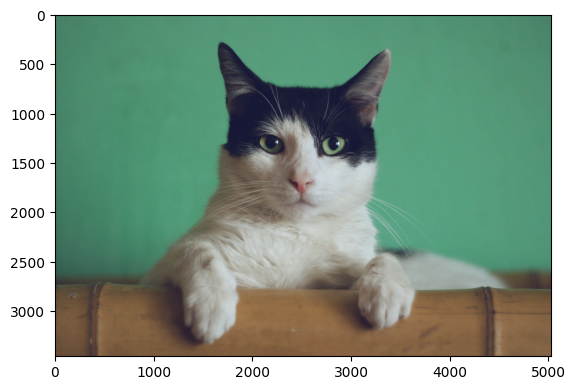

In [4]:
vgg16 = models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)

imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb')) # chargement des classes
cat = Image.open("cat.jpg")
plt.imshow(cat)

cat = cat.resize((224, 224), Image.Resampling.BILINEAR)
cat = np.array(cat, dtype=np.float32) / 255
cat = cat.transpose((2, 0, 1))
cat = np.expand_dims(cat, 0)

x = torch.Tensor(cat)
y = vgg16(x)
y = y.detach().numpy() # transformation en array numpy
imagenet_classes[np.argmax(y, axis=1)[0]]

'miniature poodle'

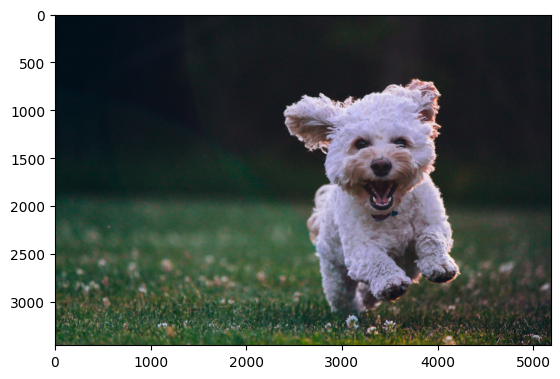

In [6]:
dog = Image.open('dog.jpg')
plt.imshow(dog)

dog = dog.resize((224, 224), Image.Resampling.BILINEAR)
dog = np.array(dog, dtype=np.float32) / 255
dog = dog.transpose((2, 0, 1))
dog = np.expand_dims(dog, 0)

x = torch.Tensor(dog)
y = vgg16(x)
y = y.detach().numpy() # transformation en array numpy
imagenet_classes[np.argmax(y, axis=1)[0]]

In [10]:
visualizer = nn.Sequential(list(vgg16.features.children())[0])

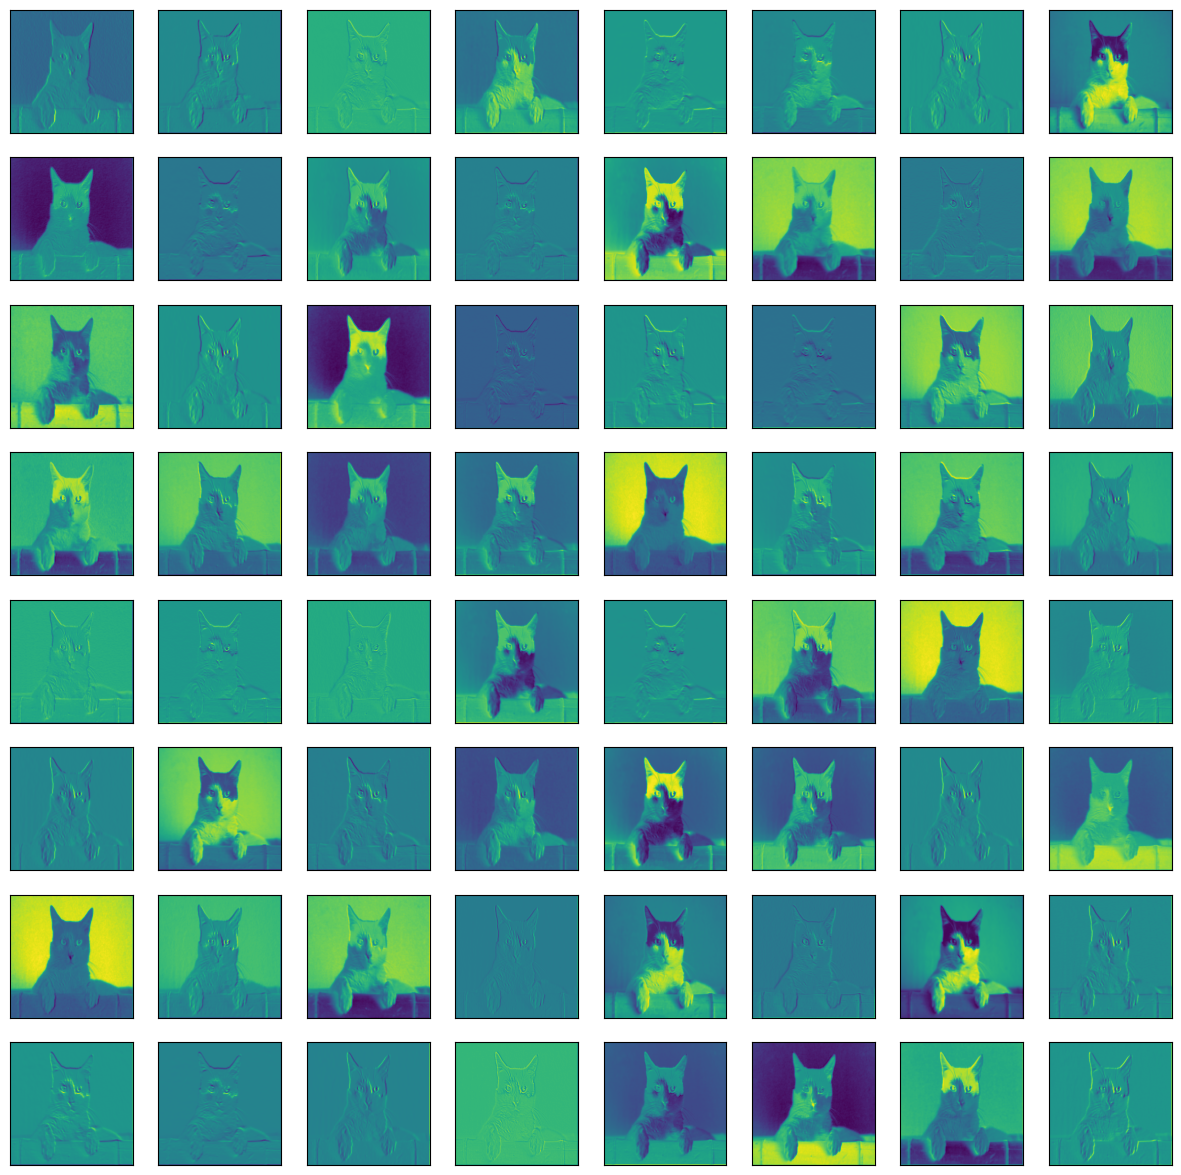

In [25]:
x = torch.Tensor(cat)
cat_map = visualizer(x)
cat_map = cat_map.squeeze().detach().numpy()
fig, axs = plt.subplots(8,8, figsize=(15,15))
for i in range(8):
    for j in range(8):
        idx = i * 8 + j
        axs[i,j].imshow(cat_map[idx])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].tick_params(bottom=False, left=False)

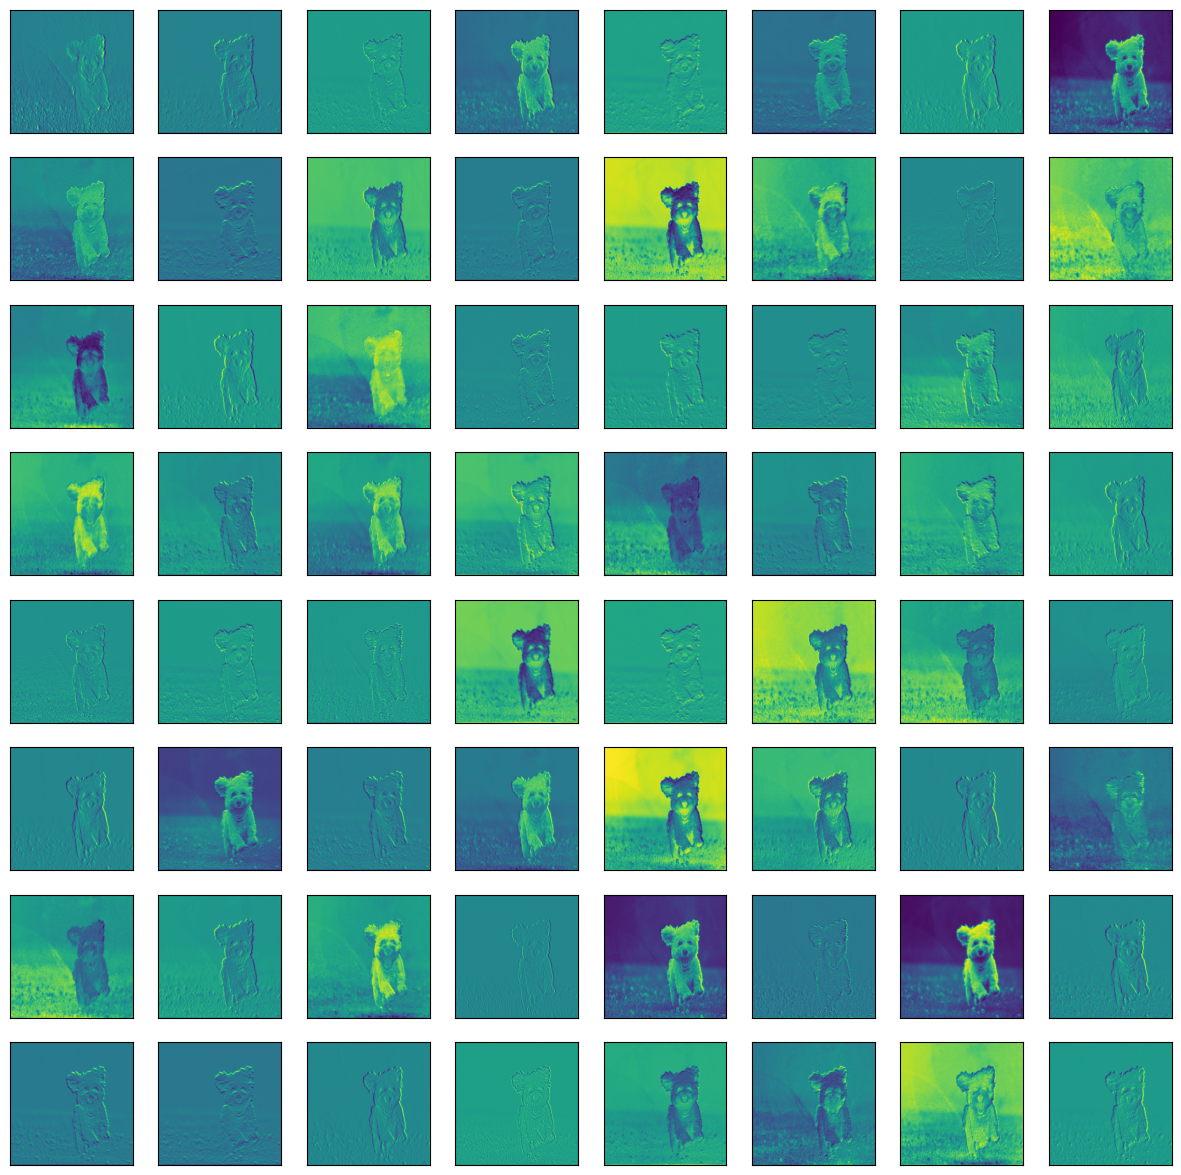

In [23]:
x = torch.Tensor(dog)
dog_map = visualizer(x)
dog_map = dog_map.squeeze().detach().numpy()
fig, axs = plt.subplots(8,8, figsize=(15,15))
for i in range(8):
    for j in range(8):
        idx = i * 8 + j
        axs[i,j].imshow(activation_map[idx])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].tick_params(bottom=False, left=False)

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [ ]:
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip
!unzip 15ScenesData.zip
!clear

In [3]:
!ls 15SceneData/test/bedroom

image_0003.jpg	image_0042.jpg	image_0082.jpg	image_0124.jpg	image_0170.jpg
image_0004.jpg	image_0043.jpg	image_0084.jpg	image_0128.jpg	image_0175.jpg
image_0006.jpg	image_0047.jpg	image_0086.jpg	image_0130.jpg	image_0176.jpg
image_0007.jpg	image_0049.jpg	image_0087.jpg	image_0131.jpg	image_0180.jpg
image_0008.jpg	image_0050.jpg	image_0088.jpg	image_0134.jpg	image_0182.jpg
image_0011.jpg	image_0052.jpg	image_0090.jpg	image_0135.jpg	image_0189.jpg
image_0013.jpg	image_0053.jpg	image_0092.jpg	image_0138.jpg	image_0190.jpg
image_0014.jpg	image_0054.jpg	image_0093.jpg	image_0140.jpg	image_0191.jpg
image_0016.jpg	image_0056.jpg	image_0095.jpg	image_0141.jpg	image_0192.jpg
image_0017.jpg	image_0059.jpg	image_0096.jpg	image_0142.jpg	image_0195.jpg
image_0018.jpg	image_0060.jpg	image_0097.jpg	image_0144.jpg	image_0196.jpg
image_0019.jpg	image_0062.jpg	image_0098.jpg	image_0148.jpg	image_0200.jpg
image_0020.jpg	image_0063.jpg	image_0103.jpg	image_0150.jpg	image_0202.jpg
image_0021.jpg	image_0064

In [3]:
class VGG16relu17(nn.Module):
    def __init__(self, vgg16):
        super().__init__()
        # Copy the entire convolutional part
        self.features = nn.Sequential( *list(vgg16.features.children()))
        # Keep a piece of the classifier: -2 to stop at relu7
        self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [20]:
PRINT_INTERVAL = 50
CUDA = True

# Cette fonction permet de recopier 3 fois une image qui
# ne serait que sur 1 channel (donc image niveau de gris)
# pour la "transformer" en image RGB. Utilisez la avec
# transform.Lambda
def duplicateChannel(img):
    img = img.convert('L')
    np_img = np.array(img, dtype=np.uint8)
    np_img = np.dstack([np_img, np_img, np_img])
    img = Image.fromarray(np_img, 'RGB')
    return img

def get_dataset(batch_size, path):
    # Ajouter le pré-traitement
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([ # Pré-traitement à faire
            transforms.Lambda(duplicateChannel),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([ # Pré-traitement à faire
            transforms.Lambda(duplicateChannel),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [46]:
def extract_features(data, model, size=50):
    X = None
    Y = None
    
    len_data = 0
    for x, y in data:
        len_data += len(x)
    
    count = 0
    for i, (x, y) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            x = x.cuda()
        # TODO Feature extraction à faire
        features = model(x)
        
        if not i:
            X = np.empty((len_data, features.shape[1]))
            Y = np.empty(len_data, dtype=int)
        
        X[count : count + x.shape[0]] = features.detach().cpu().numpy()
        Y[count : count + x.shape[0]] = y.detach().cpu().numpy()
        
        count += x.shape[0]
    X = X / np.linalg.norm(X, axis=1).reshape((-1,1))    
    return X, Y

In [47]:
BATCH_SIZE = 8
PATH = "15SceneData"

print('Instanciation de VGG16')
vgg16 = models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)

print('Instanciation de VGG16relu7')
# Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
# On créera une nouvelle classe VGG16relu7 ici
model = VGG16relu17(vgg16)    

model.eval()
if CUDA: # si on fait du GPU, passage en CUDA
    # cudnn.benchmark = True
    model = model.cuda()

# On récupère les données
print('Récupération des données')
train, test = get_dataset(BATCH_SIZE, PATH)

# Extraction des features
print('Feature extraction')
X_train, y_train = extract_features(train, model)
X_test, y_test = extract_features(test, model)

# Apprentissage et évaluation des SVM à faire
print('Apprentissage des SVM')
svm = LinearSVC(C=1.0)
# svm.fit(X_train.detach(), y_train.detach())
# accuracy = svm.score(X_test.detach(), y_test.detach()) 
svm.fit(X_train, y_train)
accuracy = svm.score(X_test, y_test) 
print('Accuracy = %f' % accuracy)

Instanciation de VGG16
Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy = 0.888107
